# Problem Statement on Sign Language Detection 
 Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.
 Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels. 


## The details on this  Dataset are as follows :

Training set: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).

Test set: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

# One Sample (Image and label) from  Sign DataSet 
![title](images/hands.png)

## As shown in above picture , each image in training set is represented as Y which would be equal to value of sign in that image and encoded as one-hot encoding .

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [8]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [21]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [22]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1] #number of training examples 
    mini_batches = []
    np.random.seed(seed)
    
    #Randomly permute a sequence of m (m=1080 samples for training and m=120 samples  for test images )
    permutation = list(np.random.permutation(m)) # generate permuted sequence of integeres upto m 
    shuffled_X = X[:, permutation] # Step 1: Shuffle (X, Y) 
    #shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    shuffled_Y = Y[:, permutation]
    
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches      
        

In [23]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [24]:
def forward_propagation_for_predict(X, parameters):
 
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

# Change the index below and run the cell to visualize some examples in the dataset.

y = 2


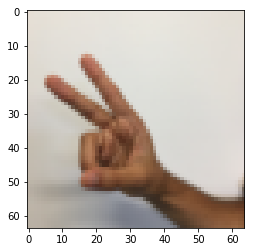

In [25]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

Note that 12288 comes from 
64×64×3
64×64×3
. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

Your goal is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built in numpy for cat recognition (but now using a softmax output). It is a great occasion to compare your numpy implementation to the tensorflow one.

The model is LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes.

# 2.1 - Create placeholders

Your first task is to create placeholders for X and Y. This will allow you to later pass your training data in when you run your session

In [26]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None])
    Y = tf.placeholder(tf.float32,shape=[n_y,None])
    return X,Y

# 2.2 - Initializing the parameters


In [27]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[25,12288],initializer = tf.contrib.layers.xavier_initializer(seed = 1)) #25 hidden nodes
    b1 = tf.get_variable("b1",[25,1],initializer = tf.contrib.layers.xavier_initializer(seed = 1)) 
    W2 = tf.get_variable("W2",[12,25],initializer = tf.contrib.layers.xavier_initializer(seed = 1)) # 12 hidden nodes
    b2 = tf.get_variable("b2",[12,1],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    W3 = tf.get_variable("W3",[6,12],initializer = tf.contrib.layers.xavier_initializer(seed = 1)) # 6 hidden nodes
    b3 = tf.get_variable("b3",[6,1],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

# 2.3 - Forward propagation in tensorflow


In [28]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    Z1 =  tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2) 
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3
        

# 2.4 Compute cost


In [29]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost


# 2.5 - Backward propagation & parameter updates
This happens automatically by tensorflow framework. 


# 2.6 - Building the model


In [30]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed = 3  
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0] 
    costs = []  
    
    X, Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()  
                
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.898954
Cost after epoch 100: 0.827941
Cost after epoch 200: 0.449933
Cost after epoch 300: 0.269627
Cost after epoch 400: 0.166629
Cost after epoch 500: 0.102671
Cost after epoch 600: 0.062712
Cost after epoch 700: 0.038805
Cost after epoch 800: 0.039123
Cost after epoch 900: 0.017993
Cost after epoch 1000: 0.009635
Cost after epoch 1100: 0.006360
Cost after epoch 1200: 0.003823
Cost after epoch 1300: 0.003502
Cost after epoch 1400: 0.001763


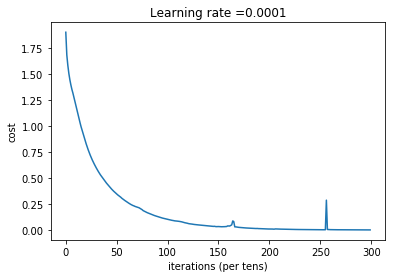

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.85833335


In [31]:
parameters = model(X_train, Y_train, X_test, Y_test)

# 2.7 - Test with your own image

C:\Users\avaish1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':


Your algorithm predicts: y = 1


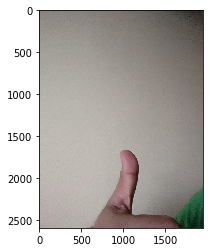

In [42]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = my_image
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))